# The Lennard-Jones Fluid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

from matplotlib.animation import FuncAnimation

from numba import njit   # Import this if you're using @njit to speed up your code
from tqdm import tqdm    # This is a very cool package that allows you to see a "progress bar" to know how far a loop has progressed

In [2]:
@njit
def lj_acc(rij):
    '''
    Get the 2D Lennard-Jones acceleration of two masses seperated by a distance rij.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    
    Returns:
    --------
    The function returns one value:
    • a : A numpy array 2 elements storing the `x` and `y` components of the acceleration.
    '''
    
    rsq = np.dot(rij,rij)    # Compute the squared distance as a dot product
    r6  = rsq*rsq*rsq        # Compute r**6
    
    f1 = 1/rsq               # Evaluate 1/r**2 and 1/r**6
    f2 = 1/r6
    
    a = 48 * f1 * f2 *( f2 - 0.5)*rij  # Evaluate the acceleration
    
    return a

@njit
def get_pe(step_pos,L):
    '''
    Get the 2D Lennard-Jones potential energy for a system of `N` masses.
    
    Parameters:
    -----------
    • pos : An `(N x 2)` numpy array of 2 elements storing the `x` and `y` values of each particle.
    
    Returns:
    --------
    The function returns one value:
    • potential : The combined potential energy of the `N` masses.
    '''
    
    N = len(step_pos)                           # Total number of particles
    
    potential = 0.0                             # Total potential energy
    
    for p in range(N-1):                        # Loop over pairs of particles
        for q in range(p+1,N):
            rij = step_pos[p] - step_pos[q]     # Find the relative position vector of the pair
            
            rij = pbc_distance(rij)
            
            rijsquare = np.dot(rij,rij)         # Compute quantities needed for the PE      
            f2 = 1.0/rijsquare                  
            f6 = f2*f2*f2
            potential += 4.*f6*(f6-1.)          # Increment potential per pair of particles
            
    return potential

@njit
def get_ke(step_vel):
    '''
    Get the kinetic energy for a system of `N` masses.
    
    Parameters:
    -----------
    • vel : An `(N x 2)` numpy array of 2 elements storing the `v_x` and `v_y` values of each particle.
    
    Returns:
    --------
    The function returns one value:
    • kinetic : The combined kinetic energy of the `N` masses.
    '''

    kinetic = 0.5*np.sum(step_vel**2)
    
    return kinetic


@njit
def pbc_distance(rij):
    '''
    Get the correct distance between two particles, accounting for periodic boundary conditions.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    
    Returns:
    --------
    The function returns one value:
    • rij : The corrected r_ij, including the effects of periodic boundary conditions.
    '''
    
    for d in range(2):
        if abs(rij[d])>0.5*L:                    # Compute the _true_ distance, taking into account
            rij[d] -= L*np.sign(rij[d])          # periodic boundary conditions
    
    return rij

@njit
def maxwell(v,T):
    '''
    Maxwell-Boltzmann distribution of velocities in two-dimensions.
    
    Parameters:
    -----------
    • v    : Number or array of velocities.
    • T    : Temperature at which the Maxwell-Boltzmann distribution is computed.
    
    Returns:
    --------
    The function returns the probability density from the Maxwell-Boltzmann distribution:
    • p : If `v` is a numpy array, `p` is a numpy array. If `v` is a number, `p` is a number.
    '''

    p = (1./T)*v*np.exp(-0.5*v*v/T)
    
    return p

In [3]:
def init_pos(Lx, Ly, Nx, Ny):
    '''
    Assign the initial positions of the particles on a regular lattice.
    
    Parameters:
    -----------
    • Lx   : x-length of the lattice.
    • Ly   : y-length of the lattice.
    • Nx   : An integer number of particles in the x-direction.
    • Ny   : An integer number of particles in the y-direction.
    
    Returns:
    --------
    The function returns one value:
    • ipos : A numpy array of (N x 2) elements storing the `x` and `y` coordinates of `N = Nx * Ny` particles.
    '''

    N = Nx*Ny                                       # Total number of particles in the lattice
    
    dx = Lx/Nx                                      # Spacing between particles along the  
    dy = Ly/Ny                                      # x and y axes
    
    ipos = np.zeros((N,2))                          # Empty array to store positions

    n=0                                             # Counter to count the number of particles
    
    for x in range(Nx):                             # Loop over all particles
        for y in range(Ny):
            ipos[n] = [dx/2 + dx*x, dy/2 + dy*y]    # Assign positions to each particle
            n+=1                                    # Increment counter
    
    return ipos


def init_vel(N):
    '''
    Assign the initial velocities of the particles.
    
    Parameters:
    -----------
    • N    : An integer number of particles.
    
    Returns:
    --------
    The function returns one value:
    • ivel : A numpy array of (N x 2) elements storing the `x` and `y` velocity components of `N` particles.
    '''
    
    ivel = np.zeros((N,2), dtype=np.float32)         # Initialise the empty array for velocities 

    T = 2.5                                          # Initial "temperature" of the system
    T0 = 1                                           # Temperature scale of the problem

    v0 = np.sqrt(2*T/T0)                             # Initial speed of each particle

    for i in range(N):                               # Loop over each particle and 
        r = 2*np.pi*np.random.random()               # assign it a random direction
        ivel[i][0] = v0 * np.cos(r)                  # Set the x and y components of the velocity
        ivel[i][1] = v0 * np.sin(r)                  # while keeping the magnitude constant

    vcm = np.sum(ivel,axis=0)/N                      # Compute the centre of mass velocity
    ivel = ivel-vcm                                  # Subtract the COM velocity so the COM is stationary

    return ivel

In [4]:
def simulate(ipos, ivel, tf=100, dt=0.01):
    '''
    Run a simulation given an initial position and velocity array.
    
    Parameters:
    -----------
    • ipos : An (Nx2) array of initial positions of N particles in 2D
    • ivel : An (Nx2) array of initial velocities of N particles in 2D
    • tf   : (optional) Final time until which the simulation will run
    • dt   : (optional) Time-step between simulation steps
    
    Returns:
    --------
    The function four values
    • pos  : An array of `(n_steps x N x 2)` elements containing the (x,y) coordinates
             of each particle at each time-step. Eg: `pos[10]` gives a snapshot of the system
             at time-step 10
    • vel  : An array of `(n_steps x N x 2)` elements containing the (v_x,v_y) coordinates
             of each particle at each time-step. Eg: `vel[10]` gives the velocities of the system
             at time-step 10
    • KE   : An array of `n_steps` elements containing the total kinetic energy of the system at each step
    • PE   : An array of `n_steps` elements containing the total potential energy of the system at each step
    '''
    
    n_steps = int(tf/dt)                                     # Number of simulation steps

    pos = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # Arrays to store the history of the particles'
    vel = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # positions and velocities

    KE = np.zeros(n_steps)                                   # Arrays to store the history of the particles'
    PE = np.zeros(n_steps)                                   # kinetic and potential energies

    pos[0] = ipos                                            # Setting initial positions to `ipos`
    vel[0] = ivel                                            # Setting initial velocities to `ivel`

    KE[0] = get_ke(vel[0])                                   # Computing initial kinetic and potential
    PE[0] = get_pe(pos[0], L=L)                              # energies

    for s in tqdm(range(1,n_steps)):                         # Loop over steps
        
        pos[s] = pos[s-1] + (dt/2)*vel[s-1]                  # Increment positions to value at intermediate point

        for i in range(N):                                   # Impose periodic boundary conditions
            for d in range(2):                               # for each dimension (x and y)
                if(pos[s][i][d] > L): pos[s][i][d] -= L
                elif(pos[s][i][d]<0): pos[s][i][d] += L

        net_a = np.zeros((N,2), dtype=np.float32)            # Empty array to store the net acceleration of each particle

        for p in range(N-1):                                 # Computing the acceleration for each _pair_ of particles              
            for q in range(p+1,N):
                rij = pos[s][p]-pos[s][q]                    # Separation between each pair

                rij = pbc_distance(rij)                      # Compute the _true_ distance, taking into account PBCs
               
                acc = lj_acc(rij)                            # Compute the accelerations of each pair of particles
                
                net_a[p] += acc                              # Use the third-law to impart equal and opposite 
                net_a[q] -= acc                              # accelerations to each particle


        vel[s] = vel[s-1] + dt*net_a                         # Update the velocity and final positions using the 
        pos[s] = pos[s] + (dt/2)*vel[s]                      # Velocity-Verlet scheme

        for i in range(N):                                   # Reimpose periodic boundary conditions
            for d in range(2):
                if(pos[s][i][d] > L): pos[s][i][d] -= L
                elif(pos[s][i][d]<0): pos[s][i][d] += L

        KE[s] = get_ke(vel[s])                               # Compute the kinetic and potential energies at 
        PE[s] = get_pe(pos[s], L=L)                          # the current step

    
    return pos, vel, KE, PE

In [5]:
##############################################
########### SIMULATION PARAMETERS ############
##############################################

Nx = 6                   # Number of particles per row initially along x
Ny = 6                   # Number of particles per row iniailly along y
N = Nx*Ny                # Total number of particles
rho = 0.5                # Density of the system
L = np.sqrt(N/rho)       # Length of the system

ipos = init_pos(Lx=L, Ly=L, Nx=Nx, Ny=Ny)  # Initial positions (square grid)
ivel = init_vel(N)                         # Initial velocities 

tf = 100                                   # Total time duration
dt = 0.01                                  # Time-step
time = np.arange(0,int(tf/dt))*dt          # Array of all time-steps

In [6]:
%%time
##############################################
##### Run a single simulation forwards #######
##############################################

# For N=25, tf=100, and dt=0.01, this should take 
# about ~ 30 s to run without Numba, and ~ 1 s with Numba

pos,vel, KE, PE = simulate(ipos, ivel, tf=tf, dt=dt)

100%|██████████████████████████████████████████████████████████| 9999/9999 [00:36<00:00, 276.67it/s]

CPU times: user 34.2 s, sys: 6.31 s, total: 40.5 s
Wall time: 36.8 s


In [7]:
%%time
##############################################
##### Run the same simulation backwards ######
##############################################

# For N=25, tf=100, and dt=0.01, this should take 
# about ~ 30 s to run without Numba, and ~ 1 s with Numba

rev_pos, rev_vel, rev_KE, rev_PE = simulate(pos[-1], -vel[-1], tf=tf, dt=dt)

100%|██████████████████████████████████████████████████████████| 9999/9999 [00:38<00:00, 258.75it/s]

CPU times: user 34.8 s, sys: 9.83 s, total: 44.6 s
Wall time: 38.6 s


In [8]:
def plot_lattice(pos,ax=None, colors=['firebrick', 'darkred']):  
    '''
    Plot a single lattice.
    
    Parameters:
    -----------
    • pos    : An array of `(N x 2)` positions representing a single snapshot of the system.
    • ax     : (Optional) An axis element. If None is provided, a new axis is produced.
    • colors : (Optional) A list of 2 elements containing the "facecolor" and "edgecolor" of the particles.
    
    Returns:
    --------
    NoneType (A plot).
    '''

    if(ax==None):
        fig, ax = plt.subplots()
    
    ax.scatter(pos[:,0], pos[:,1], color=colors[0], ec=colors[1])
    ax.set_aspect('equal')
    ax.set_xlim(0,L)
    ax.set_ylim(0,L)

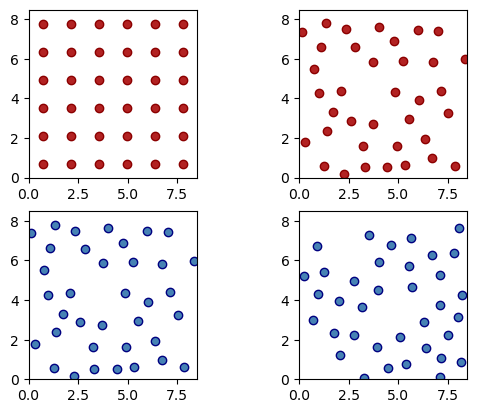

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2)

plot_lattice(ipos,axes[0][0])
plot_lattice(pos[-1],axes[0][1])

plot_lattice(pos[-1],axes[1][0], colors=['steelblue','navy'])
plot_lattice(rev_pos[-1],axes[1][1], colors=['steelblue','navy'])

<div class="alert alert-block alert-warning">
    
<b>Comment:</b> If our system had been completely deterministic, if we had started from the final configuration and flipped all the directions of the velocities, we should have returned to the original "lattice" configuration. However, as has been demonstrated above, if we just "roll back" time, we don't get back the same initial configuration! This shows that we have _lost_ determinism in our problem, due to tiny numerical errors that compound exponentially. Thus, by having a system that is _extremely_ sensitive to initial conditions, we have effectively defined a "direction" of time. In other words, the system does not behave the same way when you simulate it forwards or backwards in time, even though the laws that govern the particle dynamics (Newton's laws) are time-reversible!

If we waited long enough, we would find that the system had come to equilibrium. In other words, all memory of the initial conditions would have been completely lost. As a result, it is much more efficient and interesting to talk about _macroscopic_ properties of the system, since they are robust descriptions of the system.
</div>

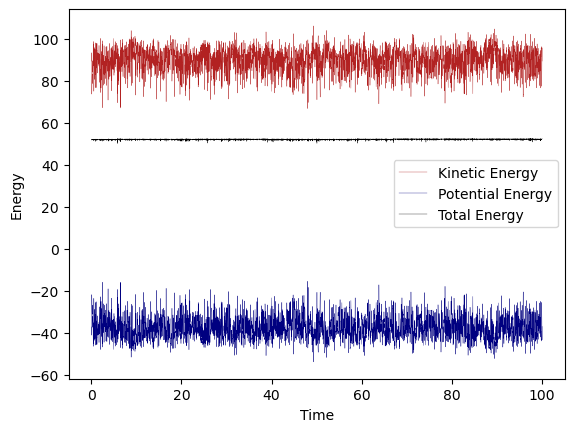

In [10]:
plt.plot(time, KE, color='firebrick', label= "Kinetic Energy", lw=0.25)   # Plot the kinetic energy
plt.plot(time, PE, color='navy', label="Potential Energy", lw=0.25)       # Plot the potential energy
plt.plot(time, (KE+PE), color='k', label="Total Energy", lw=0.25)         # Plot the total energy
plt.ylabel("Energy")
plt.xlabel("Time")
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">
    
<b>Comment:</b> Notice how while the kinetic and potential energies have large fluctuations, the total energy of the system remains almost completely constant, with small variations due to the finite step-size of the Verlet algorithm used to simulate the dynamics of the particles. This shows that we are, in fact, simulating a "microcanonical" ensemble. The net energy of the system is fixed, and it can only be redistributed amongst the particles. In such systems, we have seen, an "effective" notion of temperature _emerges_, and we can see that below by looking at the probability distribution of speeds.
    
</div>

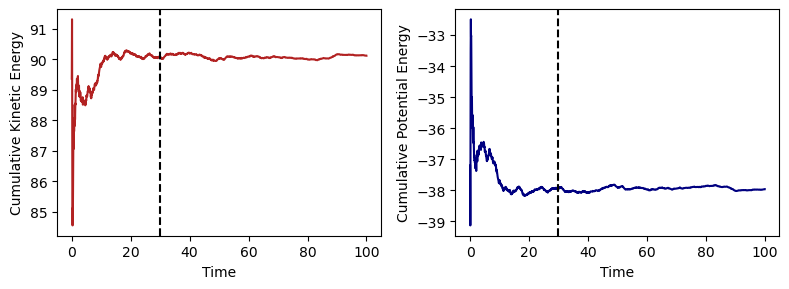

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

axes[0].plot(time, np.cumsum(KE)/np.arange(1,len(KE)+1), color='firebrick')
axes[0].set_ylabel("Cumulative Kinetic Energy")
axes[0].set_xlabel("Time")
axes[0].axvline(30, color='k', ls='--')
axes[1].plot(time, np.cumsum(PE)/np.arange(1,len(PE)+1), color='navy')
axes[1].set_ylabel("Cumulative Potential Energy")
axes[1].set_xlabel("Time")
axes[1].axvline(30, color='k', ls='--')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">
    
<b>Comment:</b> Plotting the cumulative kinetic and potential energies we see that they start to stabilise after some time (close to around $t=30$). Consequently, beyond that value of time, all the different speeds of the particles are taken, and a distribution is plotted and compared with the corresponding Maxwell-Boltzman distribution. Note that when we take the distribution of speeds, all the speeds present in all the different snapshots of the system are considered as _distinct_. In other words, we take the distribution of speeds of all particle over all instants of time.
</div>


<div class="alert alert-block alert-info">

<b>Note:</b> The `plt.hist` function has a useful `density` parameter that can be set to `True` if the quantities being binned are to be considered as probability densities. This is particularly useful if we want to compare the simulation data to theoretically predicted probability densities. 
</div> 


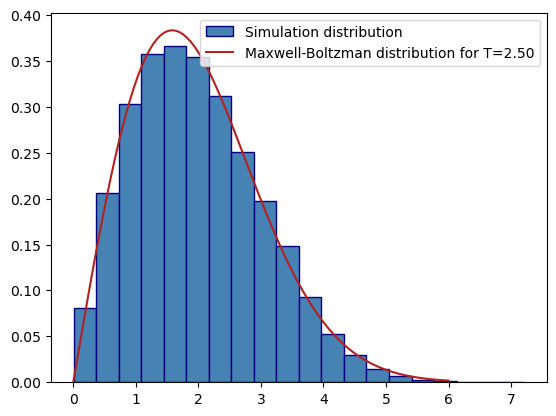

In [12]:
equilibriated_velocities = vel[time>30] # Choose a cutoff beyond which to consider the particles

equilibriated_speeds = np.sqrt(np.sum(equilibriated_velocities**2,axis=2)).flatten() # Get an array of all speeds present after t>30
temp = 0.5*np.mean(equilibriated_speeds**2) # Compute the average temperature as the mean kinetic energy (particle mass = 1)

plt.hist(equilibriated_speeds, density=True, bins=20, color='steelblue', ec='navy', label="Simulation distribution");

v_range = np.linspace(0,6,100)              # Array of speeds to plot the "theoretical" Maxwell-Boltzman distribution
plt.plot(v_range, maxwell(v_range, temp), color='firebrick', label=f"Maxwell-Boltzman distribution for T={temp:.2f}")
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">
    
<b>Comment:</b> We see that the observed distribution is remarkably close to the distribution predicted by the Maxwell-Boltzman distribution. Note however that the "temperature" here is not a parameter we can fix, but is decided by the system's energy. This is a characteristic of a "microcanonical" ensemble. If, on the other hand, we could simulate a heat-bath, then we could instead try to _set_ the temperature of the system to some value. Here, however, just like in the Demon Algorithm assignment given earlier, the temperature is an _output_ of the problem, and a consequence of the total energy being conserved, but divided amongst the individual components of the system.
</div>

In [13]:
def animate_particles(pos, save=False, save_name="lj.mp4", save_dpi=100, save_fps=100):
    '''
    Animate a set of step-wise positions of `N` particles, with the option of saving a movie.
    
    Parameters:
    -----------
    • pos       : An array of `(n_steps x N x 2)` elements representing a snapshot of the system at each step.
    • save      : (Optional) Boolean to save the animation as a movie.
    • save_name : (Optional) Name of the output video.
    • save_dpi  : (Optional) DPI of the output movie.
    • save_fps  : (Optional) Frames-per-second of the output movie.
    
    Returns:
    --------
    This function returns an animation
    • ani       : A FuncAnimation object
    '''
    
    fig, ax = plt.subplots()      # Create an empty plot and fill it with the initial position of the particles
    plot, = ax.plot(pos[0,:,0], pos[0,:,1], ls='none',color='firebrick', marker='o', mec='darkred', ms=10)

    def plotsetup():              # Function to setup the plot canvas
        ax.set_aspect('equal')
        ax.set_xlim(0,L)
        ax.set_ylim(0,L)
    
    def animate(frame):           # `Animate` function called by the FuncAnimation object below at each frame
        plot.set_data(pos[frame,:,0], pos[frame,:,1])

        return plot,
    
    steps = len(pos)              # Total steps
    
    ani = FuncAnimation(fig, animate, init_func=plotsetup(), frames=range(0,steps,10), interval=50, blit=True, repeat=True)

    if(save): # If `save==True`, a movie is created
        ani.save(save_name, dpi=save_dpi, fps=save_fps)
    
    return ani
    

<IPython.core.display.Javascript object>


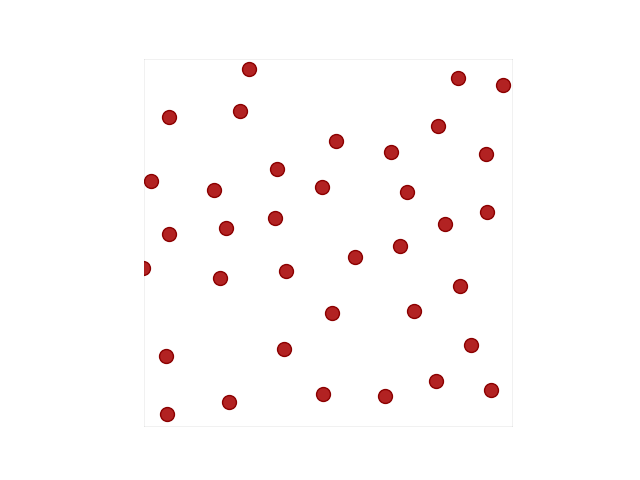

In [14]:
%matplotlib notebook
animate_particles(pos)

<div class="alert alert-block alert-warning">
    
<b>Comment:</b> For fun, we can also see an animation of the simulated system. We see that the short-range repulsion of the Lennard-Jones potential means that particles don't get too close to each other. Given the high density we have started with (and the periodic boundary conditions) this means that over short time-scales the particles on an average stay where they are. However, if a gap appears, they can move slightly larger distances. Over larger time-scales, however, the particles slowly diffuse outwards, as if performing a random walk.
</div>